In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from matplotlib.patches import Patch

In [11]:
def query( data, service ):
    df = data.query('service == "' + service + '"')
    df = df.reset_index()
    df = df.set_index(['lines'])
    #df = df.set_index(['elements'])
    #df = df.drop(df.index[0])
    return df

def plotRaw(data, service):
    df = query(dataLoadDetails, service)
    df = df.reset_index()
    durations = [ row.end - row.start for index, row in df.iterrows() ]
    #durations = [x if x >= 0 else -1 for x in durations]
    df['duration'] = durations
    df = df.drop(columns=['end','start','requestId'])
    df = df.set_index('document')
    fig = plt.figure()
    ax = df.plot.bar(stacked=True, title='Microservice response time ('+service+')', figsize=(15,7))
    ax.set_ylabel("Time (ms)")
    plt.tight_layout()
    
def load(file, sizes):
    df = pd.read_csv(file)
    df = df.merge(sizes, left_on='document', right_on='document')
    df = df.set_index(['lines','service'])
    df = df.groupby(['service','lines']).mean()
    df = df.transform(lambda x: x)
    return df

def load2(file, sizes):
    df = pd.read_csv(file)
    df = df.merge(sizes, left_on='document', right_on='document')
    durations = [ row.end - row.start for index, row in df.iterrows() ]
    durations = [x if x >= 0 else -1 for x in durations]
    df['duration'] = durations
    df = df.drop(columns=['end','start','requestId'])
    df = df.set_index(['lines','service'])
    #df = df.set_index(['elements','service'])
    df = df.groupby(['service','lines']).mean()
    #df = df.groupby(['service','elements']).mean()
    df = df.transform(lambda x: x)
    return df

def plot(data1, data2 , name1, name2, service, language):
    data1 = data1.rename({'lines': 'lines', 'duration': name1}, axis=1)
    data2 = data2.rename({'lines': 'lines', 'duration': name2}, axis=1)
    concat = pd.concat([data1, data2], axis=1, sort=False)
    concat = query(concat, service)
    ax = concat.plot.bar(title='Language service response time ('+service+') - '+language)
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("File size (lines)")

def loadDetails(file, sizes):
    df = pd.read_csv(file)
    df = df.merge(sizes, left_on='document', right_on='document')
    df = df.drop(columns=['requestId','document'])
    df = df.groupby(['service','lines']).median()
    df['router'] = df['router'] / 1000
    df['storage'] = df['storage'] / 1000
    df['workspace'] = df['workspace'] / 1000
    df['completion'] = df['completion'] / 1000
    df['definition'] = df['definition'] / 1000
    df['documentHightlight'] = df['documentHightlight'] / 1000
    df['documentSymbol'] = df['documentSymbol'] / 1000
    df['formatting'] = df['formatting'] / 1000
    df['hover'] = df['hover'] / 1000
    df['references'] = df['references'] / 1000
    df['rename'] = df['rename'] / 1000
    df['symbol'] = df['symbol'] / 1000
    df['load_model'] = df['load_model'] / 1000
    return df

def plotDetails(data, service, language):
    data = query(data, service)
    ax = data.plot.bar(stacked=True, colormap='jet', title='Language service details ('+service+') - '+language)
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("File size (lines)")
    
def loadIR(file):
    df = pd.read_csv(file)
    generation = [ (row.end - row.start) for index, row in df.iterrows() ]
    df['code generator'] = generation
    df = df.drop(columns=['end','start','elements','file','irElements'])
    df = df.groupby(['lines']).median()
    return df

def filterData(data, service, lines):
    res = data.query('service == "' + service + '" and lines == '+lines)
    res = res.drop(columns=['lines','service'])
    return res

def plotRawData(data, service, sizes, plotLimit):
    for line in sorted(sizes['lines']):
        a = filterData(data,service, str(line))
        ax = a.plot(marker='.')
        ax.set_ylim(0, plotLimit)
        
def loadAll(lsp_services, compiler_service, nablabSizes):
    # Load LSP services data and concatenate with compiler service
    lsp_services = lsp_services.merge(nablabSizes, left_on='document', right_on='document')
    durations = [ row.end - row.start for index, row in lsp_services.iterrows() ]
    durations = [x if x >= 0 else -1 for x in durations]
    lsp_services['duration'] = durations
    lsp_services = lsp_services.drop(columns=['end','start','requestId','document'])

    nablabSizes   = pd.read_csv('motiv2/documentSizeNablab4.csv')
    # Normalize df_compiler_nomad
    documents = [ row.document[row.document.rfind('/')+1:] for index, row in compiler_service.iterrows() ]
    compiler_service['document'] = documents
    documents = [ row.document[row.document.rfind('/')+1:] for index, row in nablabSizes.iterrows() ]
    nablabSizes['document'] = documents
    compiler_service = compiler_service.merge(nablabSizes, left_on='document', right_on='document')
    times = [ row.time*1000 for index, row in compiler_service.iterrows() ]
    compiler_service['time'] = times
    compiler_service = compiler_service.rename({'time': 'duration'}, axis=1)
    compiler_service = compiler_service.drop(columns=['document'])
    compiler_service['service'] = 'compiler'

    all_services = pd.concat([lsp_services, compiler_service], axis=0, sort=False)
    return all_services

def plotBoxes(data,service, sizes):
    plt.boxplot([np.array(filterData(data,service, str(line))['duration']) for line in sorted(sizes['lines'])])
    plt.title(service)
    plt.gca().xaxis.set_ticklabels(sorted(sizes['lines']))
    
def stat(data, service, size):
    res = []
    for line in sorted(sizes['lines']):
        d = filterData(data,service, str(line))['duration']
        med = float(np.median(d))
        m = float(np.mean(d))
        s = float(np.std(d))
        cov = "{:.2%}".format(s/m)
        row = [service,line,med,m,s,cov]
        res  = res + [row]
    return res

def compare(dfloc, dfnom, service):
    lines = '121'
    resLoc = dfloc.query('service == "' + service + '" and file == '+lines)
    resNom = dfnom.query('service == "' + service + '" and file == '+lines)
    print((resLoc['median'] - resNom['median'])/resLoc['median'])

    lines = '2739'
    resLoc = dfloc.query('service == "' + service + '" and file == '+lines)
    resNom = dfnom.query('service == "' + service + '" and file == '+lines)
    print((resLoc['median'] - resNom['median'])/resLoc['median'])

    lines = '5595'
    resLoc = dfloc.query('service == "' + service + '" and file == '+lines)
    resNom = dfnom.query('service == "' + service + '" and file == '+lines)
    print((resLoc['median'] - resNom['median'])/resLoc['median'])

    lines = '8213'
    resLoc = dfloc.query('service == "' + service + '" and file == '+lines)
    resNom = dfnom.query('service == "' + service + '" and file == '+lines)
    print((resLoc['median'] - resNom['median'])/resLoc['median'])

    lines = '11069'
    resLoc = dfloc.query('service == "' + service + '" and file == '+lines)
    resNom = dfnom.query('service == "' + service + '" and file == '+lines)
    print((resLoc['median'] - resNom['median'])/resLoc['median'])

def getOverheadTime(data, feature, microservice):
    return data.loc[feature]['router'] + data.loc[feature]['storage'] + data.loc[feature]['workspace']    
    
def getOverheadTimes(data):
    df = pd.DataFrame()
    df['completion'] = getOverheadTime(data, 'completion', 'completion')
    df['definition'] = getOverheadTime(data, 'definition', 'definition')
    df['documentSymbol'] = getOverheadTime(data, 'documentsymbol', 'documentSymbol')
    df['highlight'] = getOverheadTime(data, 'highlight', 'documentHightlight')
    df['hover'] = getOverheadTime(data, 'hover', 'hover')
    #df['formatting'] = getOverheadTime(data, 'formatting', 'formatting')
    df['references'] = getOverheadTime(data, 'references', 'references')
    df['rename'] = getOverheadTime(data, 'rename', 'rename')
    df['symbol'] = getOverheadTime(data, 'symbol', 'symbol')
    return df

def plotMonoDistribOverhead2(dataMono, dataDistrib, nonServiceTimes, size, ax) :
    concat = filterAndConcat(dataMono,dataDistrib, size)
    concat = concat.query('service != "formatting"')
    concat.plot.bar(figsize=(10,12), edgecolor='black', width=0.7, ax=ax)
    ax.set_title(size+' lines of code', fontdict={'fontsize': 20, 'fontweight': 'medium'}, pad=15 )
    ax.set_ylim(0, 1000)
    #ax.set_ylabel("Time (ms)", fontsize=15)
    ax.set_xlabel("", fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #nonServiceTimes = nonServiceTimes.drop(columns=['formatting'])
    nonServiceTimes.loc[int(size)].plot.bar(position=-0.00, ax=ax, color='lightgrey', width=0.35, edgecolor='black')

def filterAndConcat(dataMonolith, dataDistributed, lines):
    df1 = dataMonolith.query('lines == "' + lines + '"')
    df1 = df1.reset_index()
    df1 = df1.set_index(['service'])
    df1 = df1.drop(columns=['lines'])
    df1 = df1.rename({'service': 'service', 'duration': 'monolithic'}, axis=1)
    df2 = dataDistributed.query('lines == "' + lines + '"')
    df2 = df2.reset_index()
    df2 = df2.set_index(['service'])
    df2 = df2.drop(columns=['lines'])
    df2 = df2.rename({'service': 'service', 'duration': 'distributed'}, axis=1)
    concat = pd.concat([df1, df2], axis=1, sort=False)
    return concat

Bbox(x0=2.6, y0=0.0, x1=2.8000000000000003, y1=271.61)


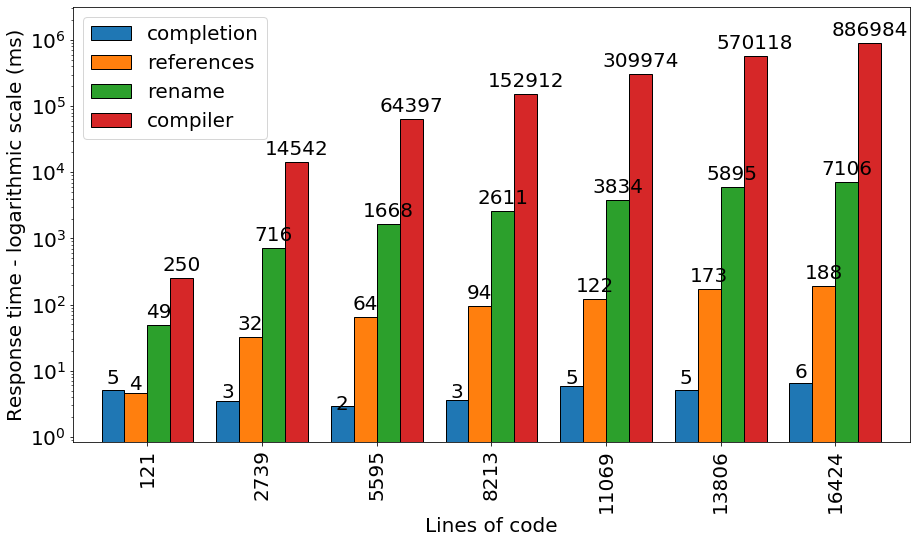

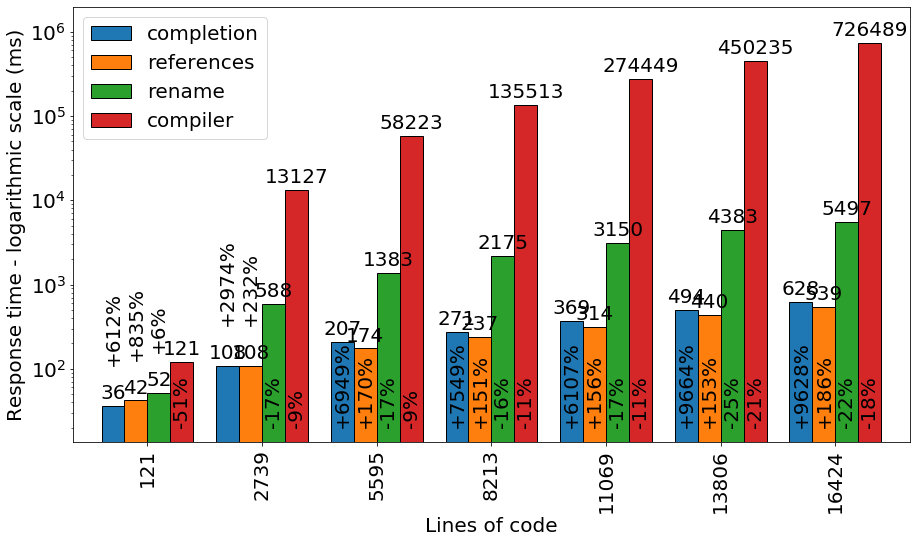

In [13]:
nablabSizes = pd.read_csv('eval/documentSizeNablab_motiv.csv')
df_nablab_monolith_local   = load('eval/nablab-monolith-dataDurations_local.csv', nablabSizes)
df_compiler_local = pd.read_csv('eval/nablab-monolith-compiler_local.csv')

# Normalize df_compiler_nomad
documents = [ row.document[row.document.rfind('/')+1:] for index, row in df_compiler_local.iterrows() ]
df_compiler_local['document'] = documents
documents = [ row.document[row.document.rfind('/')+1:] for index, row in nablabSizes.iterrows() ]
nablabSizes['document'] = documents
df_compiler_local = df_compiler_local.merge(nablabSizes, left_on='document', right_on='document')
df_compiler_local = df_compiler_local.groupby(['lines']).mean()
#df_compiler_local = df_compiler_local.groupby(['elements']).mean()
times = [ row.time*1000 for index, row in df_compiler_local.iterrows() ]
df_compiler_local['time'] = times

df_compiler_local = df_compiler_local.reset_index()
df_compiler_local = df_compiler_local.drop(['lines'], axis=1)
#df_compiler_local = df_compiler_local.drop(['elements'], axis=1)
df_compiler_local['lines'] = [121,2739,5595,8213,11069,13806,16424]
#df_compiler_local['lines'] = [121,2739,5595,8213,11069,11902,13806]
#df_compiler_local['elements'] = [752,17252,35252,51752,69752]
df_compiler_local = df_compiler_local.set_index('lines')
#df_compiler_local = df_compiler_local.set_index('elements')

dfa = query(df_nablab_monolith_local,'completion')
dfb = query(df_nablab_monolith_local,'references')
dfc = query(df_nablab_monolith_local,'rename')

dfa = dfa.drop(columns=['service'])
dfb = dfb.drop(columns=['service'])
dfc = dfc.drop(columns=['service'])

dfa = dfa.rename({'duration': 'completion'}, axis=1)
dfb = dfb.rename({'duration': 'references'}, axis=1)
dfc = dfc.rename({'duration': 'rename'}, axis=1)

df_compiler_local = df_compiler_local.rename({'time': 'compiler'}, axis=1)

concat = pd.concat([dfa, dfb, dfc, df_compiler_local], axis=1, sort=False)

ax = concat.plot.bar(figsize=(15,8), width=0.8, logy=True, edgecolor='black')
ax.set_ylabel("Response time - logarithmic scale (ms)", fontsize=20)
ax.set_xlabel("Lines of code", fontsize=20)
#ax.set_xlabel("Model elements", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.margins(0.1)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    #for rect in rects:
    for i in range(len(rects)):
        rect = rects[i]
        height = int(rect.get_height())
        if i != 28:
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=20)

bars = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]
autolabel(bars)




nablabSizes = pd.read_csv('eval/documentSizeNablab_motiv.csv')
df_nablab_distributed   = load('eval/nablab-distributed-dataDurations_nomad.csv', nablabSizes)
df_compiler_nomad = pd.read_csv('eval/nablab-distributed-compiler_nomad.csv')

# Normalize df_compiler_nomad
documents = [ row.document[row.document.rfind('/')+1:] for index, row in df_compiler_nomad.iterrows() ]
df_compiler_nomad['document'] = documents
documents = [ row.document[row.document.rfind('/')+1:] for index, row in nablabSizes.iterrows() ]
nablabSizes['document'] = documents
df_compiler_nomad = df_compiler_nomad.merge(nablabSizes, left_on='document', right_on='document')
df_compiler_nomad = df_compiler_nomad.groupby(['lines']).mean()
#df_compiler_nomad = df_compiler_nomad.groupby(['elements']).mean()
times = [ row.time*1000 for index, row in df_compiler_nomad.iterrows() ]
df_compiler_nomad['time'] = times

df_compiler_nomad = df_compiler_nomad.reset_index()
df_compiler_nomad = df_compiler_nomad.drop(['lines'], axis=1)
#df_compiler_nomad = df_compiler_nomad.drop(['elements'], axis=1)
df_compiler_nomad['lines'] = [121,2739,5595,8213,11069,13806,16424]
#df_compiler_nomad['lines'] = [121,2739,5595,8213,11069,11902,13806]
#df_compiler_nomad['elements'] = [752,17252,35252,51752,69752]
df_compiler_nomad = df_compiler_nomad.set_index('lines')
#df_compiler_nomad = df_compiler_nomad.set_index('elements')

dfa = query(df_nablab_distributed,'completion')
dfb = query(df_nablab_distributed,'references')
dfc = query(df_nablab_distributed,'rename')

dfa = dfa.drop(columns=['service'])
dfb = dfb.drop(columns=['service'])
dfc = dfc.drop(columns=['service'])

dfa = dfa.rename({'duration': 'completion'}, axis=1)
dfb = dfb.rename({'duration': 'references'}, axis=1)
dfc = dfc.rename({'duration': 'rename'}, axis=1)

df_compiler_nomad = df_compiler_nomad.rename({'time': 'compiler'}, axis=1)

concat = pd.concat([dfa, dfb, dfc, df_compiler_nomad], axis=1, sort=False)

ax = concat.plot.bar(figsize=(15,8), width=0.8, logy=True, edgecolor='black')
ax.set_ylabel("Response time - logarithmic scale (ms)", fontsize=20)
ax.set_xlabel("Lines of code", fontsize=20)
#ax.set_xlabel("Model elements", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.margins(0.1)

def autolabel(rects1, rects2):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for i in range(len(rects1)):
        offset = 12 if i==10 or i==7 or i==8 else 0 # to shift overlapping labels
        height = int(rects1[i].get_height())
        diff = int(rects1[i].get_height()) - int(rects2[i].get_height())
        percent = int(round(diff/rects2[i].get_height() * 100, 2))
        ax.annotate('{}'.format(height),
                    xy=(rects1[i].get_x() + rects1[i].get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=20)
        #if i == 0 or i == 1 or i == 2 or i == 5 or i == 6 or i == 10:
        if i == 0 or i == 1 or i == 7 or i == 8 or i == 14:
            ax.annotate('{0:+}%'.format(percent),
                        xy=(rects1[i].get_x() + rects1[i].get_width() / 2,  height ),
                        xytext=(0,40),  # 3 points vertical offset
                        textcoords='offset points',
                        ha='center', va='bottom',fontsize=20, weight='medium' , rotation='vertical'
                        #arrowprops=dict(arrowstyle='-', facecolor='black')
                       )
        elif i != 28:
            ax.annotate('{0:+}%'.format(percent),
                        xy=(rects1[i].get_x() + rects1[i].get_width() / 2, 20 ),
                        xytext=(0, 0),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',fontsize=20, weight='medium', rotation='vertical'
                       )

bars2 = [rect for rect in ax.get_children() if isinstance(rect, mpl.patches.Rectangle)]

print(bars2[3].get_bbox())

autolabel(bars2, bars)